# Chapter 3 - Linear Neural Networks for Regression

## 3.1. Linear Regression

Suppose that we wish to estimate the prices of houses (in dollars) based on their area (in square feet) and age (in years).

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch

from d2l import torch as d2l

### 3.1.1. Basics

For a *linear regression* model, we assume that the relationship between features $\mathbf{x}$ and target $y$ is approximately linear, i.e., that the conditional mean $E[Y \mid X=\mathbf{x}]$ can be expresed as a weighted sum of the features $\mathbf{x}$. In addition, we assume that any noise causing the target value to deviate from its expected value is well behaved, following a Gaussian distribution.

Typically,
* $n$ is the number of examples in the dataset,
* $\mathbf{x}^{(i)}$ denotes the i-th sample and $x_j^{(i)} denotes its j-th coordinate.

#### 3.1.1.1. Model

When the inputs consist of $d$ features, each feature is assigned an index (between 1 to $d$) and the prediction $\hat{y}$ is,

\begin{split}
\hat{y} = w_1  x_1 + \cdots + w_d  x_d + b
\end{split}
or in a dot-product form:

\begin{split}
\hat{y} = \mathbf{w}^\top \mathbf{x} + b
\end{split}
where the vector $\mathbf{x}$ corresponds to the features of a single example.

The *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$ refers to as the features of the entire dataset of $n$ examples. $\mathbf{X}$ contains one row for every example and one column for every feature.

For a collection of features $\mathbf{X}$, the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$ can be expressed as

\begin{split}
{\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b
\end{split}

Given features of a training dataset $\mathbf{X}$ and corresponding (known) labels $\mathbf{y}$, the goal of linear regression is to find the weight vector $\mathbf{w}$ and the bias term $b$ such that given features of a new data example sampled from the same distribution as $\mathbf{X}$, the new example's label will (in expectation) be predicted with the smallest error.

#### 3.1.1.2. Loss Function

*Loss functions* quantify the distance between the *real* and *predicted* values of the target. 

The most common loss function for regression is the squared error. When the prediction for an example $i$ is $\hat{y}^{(i)}$ and the corresponding true label is $y^{(i)}$, the *squared error* is

\begin{split}
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2
\end{split}

The loss on the entire training set of $n$ examples is,

\begin{split}
L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2
\end{split}

The objective is to see parameters $(\mathbf{w}^*, b^*)$ tha minimize the total loss across all training examples:

\begin{split}
\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).
\end{split}

#### 3.1.1.3. Analytic Solution

Minimizing $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$ is equivalent to

\begin{aligned}
    \partial_{\mathbf{w}} \|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2 =
    2 \mathbf{X}^\top (\mathbf{X} \mathbf{w} - \mathbf{y}) = 0
    \textrm{ and hence }
    \mathbf{X}^\top \mathbf{y} = \mathbf{X}^\top \mathbf{X} \mathbf{w}.
\end{aligned}

The solution is

\begin{split}
\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}
\end{split}
which will only be unique when the matrix $\mathbf{X}^\top \mathbf{X}$ is invertible.

#### 3.1.1.4. Minibatch Stochastic Gradient Descent

In *minibatch stochastic gradientr descent*, in each iteration $t$, we randomly sample a minibatch $\mathcal{B}_t$ consisting of a fixed number $|\mathcal{B}|$ of training examples. We then compute the gradient of the average loss on the minibatch with respect to the model parameters. Finally, we multiply the gradient by a predetermined small positive *learning rate* $\eta$, and subtract the resulting term from the current parameter values:

\begin{split}
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).
\end{split}

For quadratic losses and affine transformations, this has a closed-form expansion:

\begin{split}
\begin{aligned}
 \mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_b l^{(i)}(\mathbf{w}, b) &&  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right) 
 \end{aligned}
 \end{split}

Tunable parameters, such as minibatch size and learning rate, that are not updated in the training loop are called *hyperparameters*.

#### 3.1.1.5. Predictions

*Inference* refers broadly to any conclusion reached on the basis of evidence, including both the values of the parameters and the likely label for an unseen instance.

### 3.1.2. Vectorization for Speed

Speed is the key.

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [7]:
c = torch.zeros(n)
t = time.time()

for i in range(n):
    c[i] = a[i] + b[i]
print(f'{time.time() - t:.9f} sec')

0.114518166 sec


In [9]:
t = time.time()
d = a + b
print(f'{time.time() - t:.15f} sec')

0.000000000000000 sec


Vectorizing code often yields order-of-magnitude speedups.

### 3.1.3. The Normal Distribution and Squared Loss

Recall that a normal distribution with mean $\mu$ and variance $\sigma^2$ is given as

\begin{split}
p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right)
\end{split}

In [10]:
def normal(x, mu, sigma):
    '''Define the normal distribution'''
    p = 1 / math.sqrt(2 * math.pi * sigma ** 2)
    return p * np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

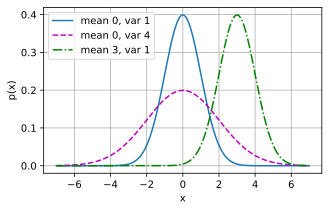

In [12]:
# visualize the normal distribution
x = np.arange(-7, 7, 0.01)

# Mean and variance pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, # x-axis
         [normal(x, mu, sigma) for mu,sigma in params], # y-axis
         xlabel='x', # x-axis label
         ylabel='p(x)', # y-axis label
         figsize=(5, 3), # figure size
         legend=[f'mean {mu}, var {sigma**2}' for mu, sigma in params] # legend
)

Assume that observations arise from noisy measurements, where the noise $\epsilon$ follows the normal distribution $\mathcal{N}(0, \sigma^2)$:

\begin{split}
y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \textrm{ where } \epsilon \sim \mathcal{N}(0, \sigma^2)
\end{split}

Thus, the *likelihood* of seeing a particular $y$ for a given $\mathbf{x}$ is

\begin{split}
P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right)
\end{split}

According to the *principle of maximum likelihood*, the best values of parameters $\mathbf{w}$ and $b$ are those that maximize the *likelihood* of the entire dataset:

\begin{split}
P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)})
\end{split}

Estimators chosen according to the principle of maximum likelihood are called *maximum likelihood estimators*.

Optimizations are more often expressed as minimization, so the goal is to *minimize* the *negative log-likelihood*:

\begin{split}
-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2
\end{split}

The second term is identical to the squared error loss except for the $\sigma$ term.

## 3.2. Object-Oriented Design for Implementation

In [13]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 3.2.1. Utilities

The `add_to_class` function allows to register functions as methods in a class *after* the class has been created. We can do so *even after* we have created instances of the class. It allows us to split the implementation of a class into multiple code blocks.

In [14]:
#@save
def add_to_class(Class):
    '''Register functions as methods in created class'''
    def wrapper(obj):
        # set the function name as the attribute name
        setattr(Class, # class to add the method to
                obj.__name__, # method name
                obj, # method
                )
    
    return wrapper

Here is how we can use the `add_to_class` function:

In [15]:
class A:
    def __init__(self):
        self.b = 1

# create an instance of A
a = A()

In [16]:
# define a function but not in class A's scope
# this function is decorated by add_to_class with class A as the argument.
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


We did not implement `.do()` method in the class `A`'s scope but were still able to use it as if `.do()` is a method of class `A`.

The `HyperParameters` class is a utility class that saves all arguments in a class's `__init__` method as class attributes. This allows us to extend constructor call signatures implicitly without additional code:

In [17]:
#@save
class HyperParameters:
    '''The base class of hyperparameters'''
    def save_hyperparameters(self, ignore=[]):
        # will be implemented later
        raise NotImplemented

We can define other class that inherits from `HyperParameters` and calls `save_hyperparameters` in the `__init__` method:

In [18]:
# call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])

        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


The `ProgressBoard` class allows to plot experiment progress interactively while it is going on and will be implemented later. The `draw` method plots a point `(x, y)` in the figure, with `label` specified in the legend. The optional `every_n` smooths the line by only showing `1/n` points in the figure. Their values are averaged from the `n` neighbor points in the original figure.

In [19]:
#@save
class ProgressBoard(d2l.HyperParameters):
    '''The board that plots data points in animation'''
    def __init__(self, xlabel=None, ylabel=None, xlim=None, ylim=None,
                 xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'],
                 colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(4.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

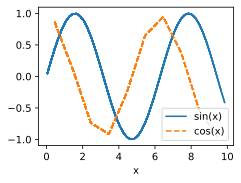

In [20]:
# example
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin(x)', every_n=2)
    board.draw(x, np.cos(x), 'cos(x)', every_n=10)

### 3.2.2. Models

The `Module` class (not from `torch` directly) is the base class of all models. There are three methods we need to implement:
1. `__init__` stores the learnable parameters,
2. `training_step` accepts a data batch to return the loss value, and
3. `configure_optimizers` return the optimization methods.
4. (optional) `validation_step` reports the evaluation measures.
5. sometimes a separate `forward` method is used.

In [21]:
class Module(nn.Module, d2l.HyperParameters):
    '''The base class of models'''
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplemented
    
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)
    
    def plot(self, key, value, train):
        '''Plot a point in animation'''
        assert hasattr(self, 'trainer'), 'Trainer is not initialized'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
            
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
        
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), # model prediction
                      batch[-1], # ground truth
                      )
        self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), # model prediction
                      batch[-1], # ground truth
                      )
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplemented

### 3.2.3. Data

The `DataModule` class is the base class for data.

In [22]:
class DataModule(d2l.HyperParameters):
    '''The base class of data modules'''
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplemented
    
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    
    def val_dataloader(self):
        return self.get_dataloader(train=False)

### 3.2.4. Training

The `Trainer` class trains the learnable parameters in the `Module` class with data specified in `DataModule` class.

In [23]:
class Trainer(d2l.HyperParameters):
    '''The base class for training models with data'''
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        super().__init__()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()

        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = len(self.val_dataloader) if self.val_dataloader is not None else 0

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)

        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0

        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplemented

## 3.3. Synthetic Regression Data

In [24]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.3.1. Generating the Dataset

We will generate 1000 examples with 2-dimensional features drawn from a standard normal distribution. The design matrix $\mathbf{X}$ belongs to $\mathbb{R}^{1000 \times 2}$. We will also generate each label by applying a *ground truth* linear function, corrupting them via additive noise $\boldsymbol{\epsilon}$, drawn independently and identically for each example:

\begin{split}
\mathbf{y}= \mathbf{X} \mathbf{w} + b + \boldsymbol{\epsilon}
\end{split}
where $\boldsymbol{\epsilon}$ is drawn from a normal distribution with mean $\mu= 0$ and standard deviation $\sigma=0.01$.

We will code up this as a class inherited from `d2l.DataModule` and also allow the setting of any additional hyperparameters:

In [25]:
class SyntheticRegressionData(d2l.DataModule):
    '''Synthetic data fro linear regression'''
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        super().__init__()

        # save hyperparameters
        self.save_hyperparameters()
        # total number of data points
        n = num_train + num_val

        # generate design matrix
        self.X = torch.randn(n, # number of data points
                             len(w), # number of features
                             )
        # generate vector of noise
        noise = torch.randn(n, 1) * noise
        # generate labels
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

Set the true parameters:

In [26]:
w = torch.tensor([5, -1.6])
b = 9.2

In [27]:
# create a synthetic dataset
data = SyntheticRegressionData(w, b)

print('features:', data.X[0], '\nlabel:', data.y[0])

features: tensor([ 0.7425, -1.3687]) 
label: tensor([15.1057])


### 3.3.2. Reading the Dataset

We will implement the `get_dataloader` method, registering it in the `SyntheticRegressionData` class via `add_to_class` (mentioned in Section 3.2.1).

In [28]:
@d2l.add_to_class(SyntheticRegressionData) # add the below function to the class SyntheticRegressionData
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # the examples are read in random order
        random.shuffle(indices)

    else:
        # the examples are read in sequential order
        indices = list(range(self.num_train, self.num_train + self.num_val))

    for i in range(0, len(indices), self.batch_size):
        # return a batch of examples
        batch_indices = torch.tensor(indices[i : i + self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

Each minibatch of features provides with both its size and the dimensionality of input features:

In [29]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


The `add_to_class` decorator allows to add a method to the `SyntheticRegressionData` class *after* creating the `data` object.

### 3.3.3. Concise Implementation of the DataLoader

Instead of implementing our own iterator, we can call the existing API in PyTorch to laod data.

In [31]:
@d2l.add_to_class(d2l.DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    # return a batch of examples
    tensors = tuple(a[indices] for a in tensors)
    # create a tensor dataset
    dataset = torch.utils.data.TensorDataset(*tensors)

    return torch.utils.data.DataLoader(dataset,
                                       batch_size=self.batch_size,
                                       shuffle=train,
                                       )

@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

The new dataloader behaves as before but more efficient:

In [32]:
X, y = next(iter(data.train_dataloader()))

print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [33]:
# check the number of examples in a batch
len(data.train_dataloader())

32

## 3.4. Linear Regression Implementation from Scratch

In this section, we will rely only on tensors and automatic differentiation.

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

### 3.4.1. Defining the Model

We need to initialize weights by drawing random numbers from a normal distribution with mean 0 and a standard deviation of 0.01. We also set the bias to 0.

In [2]:
class LinearRegressionScratch(d2l.Module):
    '''The linear regression model implemented from scratch'''
    def __init__(self, num_inputs, lr, sigma=0.01):
        # inherit from the base class d2l.Module
        super().__init__()

        # save hyperparameters using the base class
        self.save_hyperparameters()
        
        # initialize parameters
        self.w = torch.normal(0, sigma, size=(num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

Next, we must define the model. The resulting `forward` method is registered in the `LinearRegressionScratch` class via `add_to_class` decorator:

In [3]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    # X w + b
    return torch.matmul(X, self.w) + self.b

### 3.4.2. Defining the Loss Function

In [4]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    # squared loss
    l = (y_hat - y) ** 2 / 2
    return l.mean()

### 3.4.3. Defining the Optimization Algorithm

Implementing the minibatch SGD.

Since the loss is computed as an average over the minibatch, we do not need to adjust the learning rate against the batch size.

The `SGD` class is inherited as a subclass of `d2l.HyperParameters` to have a similar API as the built-in SGD optimizer. We also update the parameters in the `step` method and set all gradients to 0 in the `zero_grad` method which must be run before a backpropagation step.

In [5]:
class SGD(d2l.HyperParameters):
    '''Minibatch stochastic gradient descent'''
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            # update parameters
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                # reset gradient
                param.grad.zero_()

Next we need to define the `configure_optimizers` method, which returns an instance of the `SGD` class:

In [6]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

### 3.4.4. Training

In summary, we will execute the following loop:
* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

Next, the `prepare_batch` and `fit_epoch` methods are registered in the `d2l.Trainer` class (introduced in Section 3.2.4):

In [7]:
@d2l.add_to_class(d2l.Trainer)
def preprare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()

    for batch in self.train_dataloader:
        loss = self.model.training_step(self.preprare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0: # gradient clipping
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.preprare_batch(batch))
        self.val_batch_idx += 1

We will use `SyntheticRegressionData` class and pass in some ground truth parameters. In general, both the number of epochs and the learning rate are hyperparameters. Setting hyperparameters is tricky and we will usually want to use a three-way split, one set for training, a second for hyperparameter selection, and the third reserved for the final evaluation.

In [8]:
# create synthetic data
w = torch.tensor([2, -3.4])
b = 4.2
data = d2l.SyntheticRegressionData(w, b)

In [9]:
# create a linear regression model
num_inputs = 2
lr = 0.03
model = LinearRegressionScratch(num_inputs, lr)

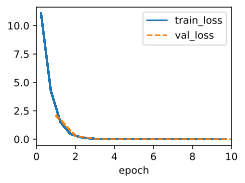

In [10]:
# create a trainer
max_epochs = 10
trainer = d2l.Trainer(max_epochs)
trainer.fit(model, data)

We can now compare the resulting parameters with the true parameters:

In [11]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([-1.1969e-04, -7.6771e-05])
error in estimating b: tensor([0.0004])


## 3.5. Concise Implementation of Linear Regression

In [1]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 3.5.1. Defining the Model

In PyTorch, the fully connected layer is defined in `Lienar` and `LazyLinear` classes. The `LazyLinear` allows users to specify only the output dimension.

In [2]:
class LinearRegression(d2l.Module):
    '''Linear regression model implemented using PyTorch high-level APIs'''
    def __init__(self, lr):
        super().__init__()

        self.save_hyperparameters()

        self.net = nn.LazyLinear(1)
        # initialize parameters
        self.net.weight.data.normal_(0, # mean
                                     0.01, # std
                                     )
        self.net.bias.data.fill_(0)

We invoke the built-in `__call__` method of the predefined layers in the `forward` method:

In [3]:
@d2l.add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X)

### 3.5.2. Defining the Loss Function

In [4]:
@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

### 3.5.3. Defining the Optimization Algorithm

In [5]:
@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

### 3.5.4. Training

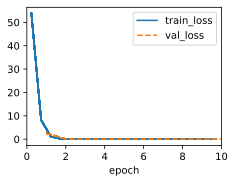

In [6]:
# create synthetic data
w = torch.tensor([5, -1.54])
b = 9.1
data = d2l.SyntheticRegressionData(w, b)

# create a linear regression model
lr = 0.03
model = LinearRegression(lr)

# create a trainer
max_epochs = 10
trainer = d2l.Trainer(max_epochs)
trainer.fit(model, data)


In [7]:
@d2l.add_to_class(LinearRegression)
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)

w, b = model.get_w_b()

In [8]:
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([-2.7180e-05,  2.4974e-04])
error in estimating b: tensor([5.5313e-05])


## 3.6. Generalization

### 3.6.1. Training Error and Generalization Error

The *IID assumption* assumes that the training data and the test data are drawn *independently* from *identical* distributions.

The *training error* $R_\textrm{emp}$ is a *statistic* calculated on the training dataset, and the *generalization error* $R$ is an *expectation* taken with respect to the underlying distribution. Formally, the training error is expressed as a *sum*:

\begin{split}
R_\textrm{emp}[\mathbf{X}, \mathbf{y}, f] = \frac{1}{n} \sum_{i=1}^n l(\mathbf{x}^{(i)}, y^{(i)}, f(\mathbf{x}^{(i)}))
\end{split}
while the generalization error is expressed as an integreal:

\begin{split}
R[p, f] = E_{(\mathbf{x}, y) \sim P} [l(\mathbf{x}, y, f(\mathbf{x}))] =
\int \int l(\mathbf{x}, y, f(\mathbf{x})) p(\mathbf{x}, y) \;d\mathbf{x} dy
\end{split}
Problematically, we can never calculate the generalization error $R$ exactly. No one can tell the precise form of the density function $p(\mathbf{x}, y)$. In addition, we cannot sample an infinite stream of data points. Thus, we must *estimate* the generalization error by applying the model to an independent test set constituted of a random selection of examples $\mathbf{X}'$ and labels $\mathbf{y}'$ that were withheld from the training set. This consists of applying the same formula that was used for calculating the empirical training error but to a test set $\mathbf{X}', \mathbf{y}'$.

#### 3.6.1.1. Model Complexity

When a model is capable of fitting arbitrary labels, low training error does not necessarily imply low generalization error. *However, it does not necessarily imply high generalization error either!* In these cases we must rely more heavily on our holdout data to certify generalization after the fact. Error on the holdout data, i.e., validation set, is called the validation error.

### 3.6.2. Underfitting or Overfitting

If the model is unable to reduce the training error, that could mean that our model is too simple (i.e., insufficiently expressive) to capture the pattern that we are trying to model. Moreover, since the *generalization gap* ($R_\textrm{emp} - R$) between the training and generalization errors is small, we can choose a more complex model. This phenomenon is known as *underfitting*.

*Overfitting* indicates that the training error is significantly lower than the validation error.

### 3.6.3. Model Selection

We should never rely on the test data for model selection, and yet we cannot rely solely on the training data for model selection either because we cannot estimate the generalization error on the very data that we use to train the model.

In summary, keep a separate validation data from training data and use it for model selection.

#### 3.6.3.1. Cross-Validation

In *K-fold cross-validation*, the original training data is split into *K* non-overlapping subsets. Then model training and validation are executed *K* times, each time training on *K-1* subsets and validating on a different subset. Finally, the training and validation errors are estimated by averaging over the results from the *K* experiments.

## 3.7. Weight Decay

The *monimials* are the natrual extensions of ploynomials to multivariate data. They are simply the products of powers of variables. The degree of a monomial is the sum of the powers. For example, $x_1^2 x_2$ and $x_3 x_5^2$ are both monomials of degree 3.

The number of terms with degree $d$ blows up rapidly as $d$ grows larger. Given $k$ variables, the number of monomials of degree $d$ is ${k - 1 + d} \choose {k - 1}$.

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

### 3.7.1. Norms and Weight Decay

*Weight decay* operates by restricting the values that the parameters can take, rather than directly manipulating the number of parameters.

To measure the complexity of a linear function $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$, we can use some norm of its weight vector, e.g., $\| \mathbf{w} \|^2$. To ensure a small weight vector, we can add its norm to it as a penalty term to the problem of minimizing the loss, so that we now replace the original objective, *minimizing the prediction loss on the training labels*, with a new objective, ***minimizing the sum of the prediction loss and the penalty term***. If the weight vector grows too large, the learning algorithm may focus on minimizing the weight norm $\| \mathbf{w} \|^2$ rather than minimizing the training error.

Recall the loss function for a linear regression:
\begin{split}
L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2
\end{split}
where $\mathbf{x}^{(i)}$ are the features, $y^{(i)}$ is the label for any data example $i$, and $(\mathbf{w}, b)$ are the weight and bias parameters, respectively.

The new loss function with $\ell_2$ norm is given as
\begin{split}
L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2
\end{split}
where $\lambda$ is a *regularization constant* which is a nonnegative hyperparameter for trade-off in loss function. For $\lambda=0$, the loss function is the original loss function. For $\lambda>0$, we restrict the size of $\| \mathbf{w} \|$. The $\frac{1}{2}$ is used to cancel out the 2 when we take the derivative of a quadratic function.

While $\ell_2$-regularized linear models constitute the classic *ridge regression* alrogithm, $\ell_1$-regularized linear regression is a similarly fundamental method in statistics, known as *lasso regression*.
* $\ell_2$ norm places an outsize penalty on large components of the weight vector. This biases the learning algorithm towards models that distribute weight evenly across a larger number of features.
* $\ell_1$ norm leads to models that concentrate weights on a small set of features by clearning the other weights to zero. This gives us an effective method for *feature selection*.

The minibatch stochastic gradient descent update for $\ell_2$-regularized regression as
\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)
\end{aligned}
As before, $\mathbf{w}$ is updated based on the amount by which the estimate differs from the observation. However, the size of $\mathbf{w}$ is also shrunk towards zero. This is why this method is called *"weight decay"*: *given the penalty term alone, the optimization algorithm decays the weight at each step of training*.

### 3.7.2. High-Dimensional Linear Regression